In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from modAL.uncertainty import uncertainty_sampling
import numpy as np
import matplotlib.pyplot as plt
import os


## Setting random seed 

In [2]:
np.random.seed(13)
torch.manual_seed(13)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [4]:
indices = np.arange(len(train_data))
np.random.shuffle(indices)

initial_labeled_size = 1000
labeled_indices = indices[:initial_labeled_size].tolist()
unlabeled_indices = indices[initial_labeled_size:].tolist()

def get_data_loader(indices, batch_size=64, shuffle=True):
    subset = Subset(train_data, indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle)

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
def train_model(model, train_loader, device="cpu", epochs=3):
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            loss = criterion(model(data), label)
            loss.backward()
            optimizer.step()

def test_model(model, test_loader, device="cpu"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            outputs = model(data)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == label).sum().item()
            total += label.size(0)
    return 100 * correct / total

In [7]:
def query_uncertainty_sampling(model, unlabeled_indices, n_instances, device='cpu'):
    model.eval()
    subset = Subset(train_data, unlabeled_indices)
    loader = DataLoader(subset, batch_size=128, shuffle=False)

    all_probs = []
    for data, _ in loader:
        data = data.to(device)
        with torch.no_grad():
            outputs = model(data)
            probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

    all_probs = np.vstack(all_probs)
    uncertainty = 1 - np.max(all_probs, axis=1)
    selected_pos = np.argsort(uncertainty)[-n_instances:]
    selected_indices = [unlabeled_indices[i] for i in selected_pos]
    return selected_indices

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_accs = []
test_accs = []

n_queries = 10
query_batch_size = 500
epochs_per_round = 3

for round_num in range(n_queries):
    print(f"\n=== Round {round_num + 1}/{n_queries} ===")
    
    train_loader = get_data_loader(labeled_indices)
    model = SimpleCNN()
    train_model(model, train_loader, device=device, epochs=epochs_per_round)
    
    train_acc = test_model(model, train_loader, device)
    test_acc = test_model(model, test_loader, device)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
    
    if len(unlabeled_indices) == 0:
        break

    selected_indices = query_uncertainty_sampling(model, unlabeled_indices, query_batch_size)
    
    labeled_indices += selected_indices
    unlabeled_indices = list(set(unlabeled_indices) - set(selected_indices))


=== Round 1/10 ===
Train Acc: 34.10% | Test Acc: 30.56%

=== Round 2/10 ===
Train Acc: 33.93% | Test Acc: 32.25%

=== Round 3/10 ===
Train Acc: 33.70% | Test Acc: 33.99%

=== Round 4/10 ===
Train Acc: 29.60% | Test Acc: 32.17%

=== Round 5/10 ===
Train Acc: 38.30% | Test Acc: 40.54%

=== Round 6/10 ===
Train Acc: 35.83% | Test Acc: 38.37%

=== Round 7/10 ===
Train Acc: 39.40% | Test Acc: 42.35%

=== Round 8/10 ===
Train Acc: 38.76% | Test Acc: 42.93%

=== Round 9/10 ===
Train Acc: 37.98% | Test Acc: 41.66%

=== Round 10/10 ===
Train Acc: 40.40% | Test Acc: 43.64%


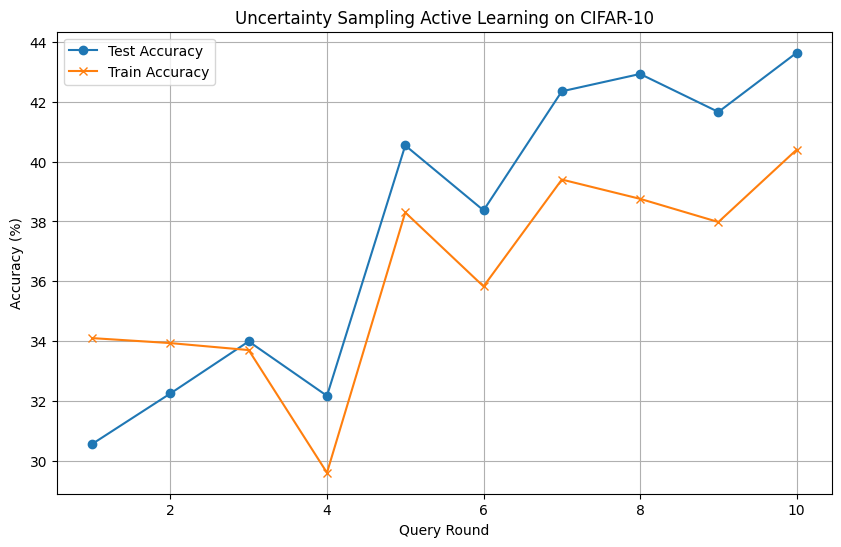

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_queries + 1), test_accs, label='Test Accuracy', marker='o')
plt.plot(range(1, n_queries + 1), train_accs, label='Train Accuracy', marker='x')
plt.xlabel('Query Round')
plt.ylabel('Accuracy (%)')
plt.title('Uncertainty Sampling Active Learning on CIFAR-10')
plt.legend()
plt.grid(True)
plt.show()